## Setting up metadata for Exloo Infrasound Array (EXL) & interaction with NRL

Author: Jelle Assink (jelle.assink@knmi.nl)

This code is distributed under the terms of the
GNU General Public License, Version 3
(https://www.gnu.org/licenses/gpl-3.0.en.html)

# Import packages

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [2]:
from obspy.core.inventory.util import Site
from obspy.core.inventory import Station
from obspy.clients.nrl import NRL
from obspy import UTCDateTime

In [3]:
from pysametadata.core.metadata import Metadata
from pysametadata.sensors.knmi import KNMImb
from pysametadata.dataloggers.kinemetrics import Obsidian

In [4]:
import numpy as np

# Setting up the basis of an `Metadata` object

As an example, metadata will be prepared for the first element of the Exloo Infrasound Array (EXL), i.e. NL.EXL01.

The first step is define the inventory and network attributes and describe the site information.

In [5]:
NL_EXL = Metadata(code='NL', name='EXL', institute='KNMI',
                  description='Royal Netherlands Meteorological Institute')
NL_EXL.set_network(code=NL_EXL.code,
                   description='Netherlands Seismic and Acoustic Network',
                   starttime=UTCDateTime('1993-01-01T00:00:00'))
net = NL_EXL.network
NL_EXL.inventory.networks.append(NL_EXL.network)

In [6]:
site_info = Site('Exloo Infrasound Array',
                 description='Exloo Infrasound Array',
                 town='Exloo', country='The Netherlands')

Once an Obspy `Network` object is defined, a `Station` object can be added, so in this example station `NL.EXL01`:

In [7]:
net.stations.append(Station('EXL01', 52.908069, 6.865355, 6.0, vault=1.0))

Now the description of the site and its opening time can be added:

In [8]:
sta = net[0]
t0 = UTCDateTime('2017-07-20T18:00:00')
NL_EXL.set_station(sta, site_info, starttime=t0)
print(sta)

Station EXL01 (Exloo Infrasound Array)
	Station Code: EXL01
	Channel Count: None/None (Selected/Total)
	2017-07-20T18:00:00.000000Z - 
	Access: open Alternate Code: EXL 
	Latitude: 52.91, Longitude: 6.87, Elevation: 6.0 m
	Available Channels:



# Setting up response information from home-made metadata classes

`NL.EXL01` consists of a KNMI microbarometer (KNMI-mb) with a [Kinemetrics Obsidian datalogger](https://kinemetrics.com/post_products/obsidian/). The sensitivity and response information of these instruments are provided by the `KNMImb` and `Obsidian` classes that are part of `pysametadata`.

The response of the KNMI microbarometer can be described by its poles and zeros, which have been derived from the properties of the instrument. In particular, the low-frequency cut-off is determined by the properties of the capillary and the backing volume. Its high-frequency cut-off is here determined by the wind noise reduction system (*wnrs*) that effectively acts as a low-pass filter. Its corner frequency is dependent on the length of the *wnrs*. More information can be found in [Mentink and Evers (2011)](https://doi.org/10.1121/1.3596718) as well as the [PhD thesis (2008)](http://resolver.tudelft.nl/uuid:4de38d6f-8f68-4706-bf34-4003d3dff0ce) by Läslo Evers. 

The sensitivity of the KNMI-mb has emperically been determined at approximately 17 mV/Pa.

The Obsidian datalogger is configured with a sample rate of 100 Hz and has a 20 V full-scale voltage, meaning that voltages between -20 V and +20 V can be facilitated. As the datalogger in theory has 24 bits available, this means that $2^{24}$ counts are to be divided over a voltage difference of 40 V. Therefore, the gain **G** of the datalogger is:

$$
G = \frac{2^{24}}{40} \approx 419430 \frac{\mbox{counts}}{\mbox{Volt}}
$$

Putting all this information together we get the following design:

In [9]:
channel = NL_EXL.set_channel('HDF', sta, location='00',
                             sample_rate=100.0, starttime=t0)
my_sensor = KNMImb(channel, model='500s', wnrs_diameter=10.0)
my_sensor.set_response(stage=1)
my_logger = Obsidian(channel, V_max=20.0,
                     sens_freq=my_sensor.sens_freq, serial_number=1074)
my_logger.set_response(stage=2)
NL_EXL.calculate_sensitivity(channel)
sta.channels.append(channel)

The constructed response can be reviewed and be plotted:

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 7425.05 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 419430


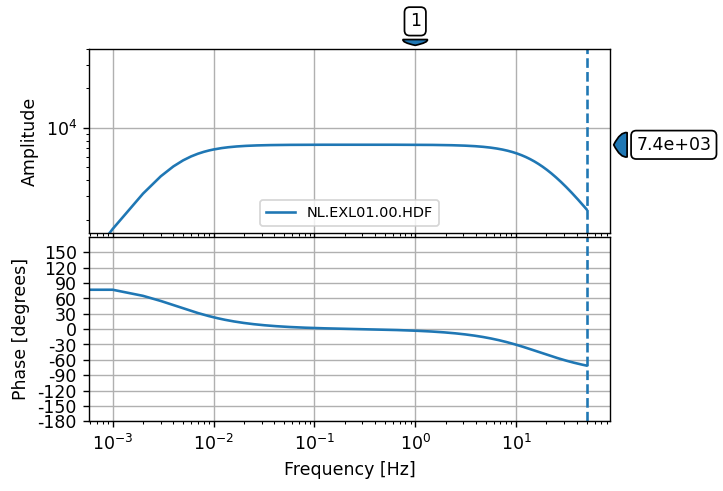

In [10]:
print(channel.response)
fig=channel.plot(1e-3, unwrap_phase=True, label=channel.seed_id, plot_degrees=True)
ax_list=fig.axes

# Comparison with NRL Kinemetrics Obsidian response

Now, a new channel response is defined. The KNMI-mb response and the common attributes of the Obsidian datalogger will be kept, but instead of using the 'home-made' Obsidian response (which is a simple flat line with a gain determined by the numbers of bits available and the full-scale voltage), now we are going to use the official response file that is provided by the Nominal Response Library (NRL). This response file also includes all the finite impulse response (FIR) digital filters that are part of the dataloggers.

First set up a new `Channel`, again with the `KNMImb` and `Obsidian` objects. Note that we do not apply the `set_response()` methods yet.

In [11]:
channel_nrl = NL_EXL.set_channel('HDF', sta, location='01',
                             sample_rate=100.0, starttime=t0)
my_sensor = KNMImb(channel_nrl, model='500s', wnrs_diameter=10.0)
my_logger = Obsidian(channel_nrl, V_max=20.0,
                     sens_freq=my_sensor.sens_freq, serial_number=1074)

The next step is to initialise ObsPy's built-in NRL client to connect to the online database.

In [12]:
nrl = NRL()

There are many response files available, depending on the settings of the datalogger. To mimic our situation, we take the response model for a Kinemetrics Obsidian datalogger with a full-scale setting of 20 Vp (= 40 Vpp). The datalogger samples at 100 Hz.

In [13]:
print(nrl.dataloggers['Kinemetrics']['Rock Family (Basalt, Granite, Dolomite, Obsidian)']['1']['40']['Non-causal']['100'])

('Rock family, gain 1, 40 Vpp, 100 sps, non-causal filter', 'http://ds.iris.edu/NRL/dataloggers/kinemetrics/rock/RESP.XX.NK340..HHZ.ROCK.1.40.100.NonC')


Now download the response information, to be attached to the `Channel` object.

In [14]:
# Obtain response information for Obsidian digitiser
obsidian_keys = ['Kinemetrics',
                 'Rock Family (Basalt, Granite, Dolomite, Obsidian)',
                 '1', '40', 'Non-causal', '100']
obsidian_response = nrl.get_datalogger_response(obsidian_keys)
print(obsidian_response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 420168 defined at 0.020 Hz
	8 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 8: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


This information should be attached to the channel. The first stage should be replaced with the response information of `my_sensor`.

In [15]:
channel_nrl.response = obsidian_response
channel_nrl.response.response_stages.pop(0)
my_sensor.set_response(stage=1)

And voilà:

In [16]:
print(channel_nrl.response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 420168 defined at 0.020 Hz
	8 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 8: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Last thing to do is to recalculate the overall gain and sensitivity frequency, to be set to the values from the sensor (the first stage). Then we can add the `Channel` object to the `Station` object.

In [17]:
NL_EXL.calculate_sensitivity(channel_nrl)
sta.channels.append(channel_nrl)

Now plot the result.

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 7438.11 defined at 1.000 Hz
	8 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 8: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


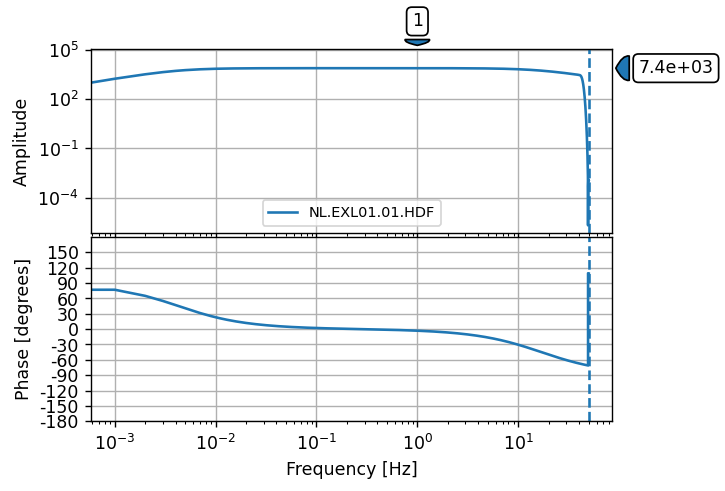

In [18]:
print(channel_nrl.response)
fig=channel_nrl.plot(1e-3, unwrap_phase=True, label=channel_nrl.seed_id, plot_degrees=True)
ax_list=fig.axes

## Comparing response models

Now let's compare the different response curves that are saved in `channel` and `channel_nrl`. For that, it is best to define a convenience function `get_response_function`, which returns the complex-valued response function from an ObsPy `Channel` object:

In [19]:
def get_response_function(channel,min_freq):
    sampling_rate = channel.sample_rate
    nyquist = channel.sample_rate / 2.0
    nfft = int(sampling_rate / min_freq)
    t_samp = 1./sampling_rate
    cpx_response, freq = channel.response.get_evalresp_response(t_samp=t_samp, nfft=nfft, output='VEL')
    return(cpx_response,freq)

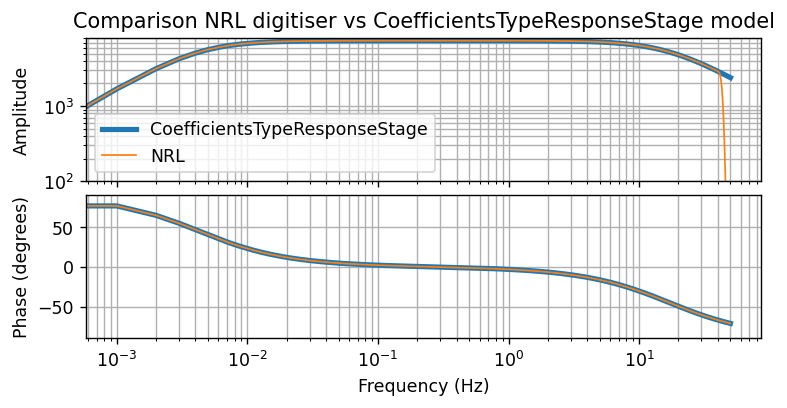

In [20]:
(H,f) = get_response_function(channel,1e-3)
(H_nrl,f) = get_response_function(channel_nrl,1e-3)

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 3 ))
ax[0].set_title('Comparison NRL digitiser vs CoefficientsTypeResponseStage model')
ax[0].loglog(f,abs(H),linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[0].loglog(f,abs(H_nrl),linewidth=1.0,label='NRL')
ax[0].set_ylim([1e2, 8e3])
ax[0].grid(which='both')
ax[0].legend()
ax[0].set(ylabel='Amplitude')


phase = np.angle(H, deg=True)
phase_nrl = np.angle(H, deg=True)
ax[1].semilogx(f,phase,linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[1].semilogx(f,phase_nrl,linewidth=1.0,label='NRL')
ax[1].set_ylim([-90,90])
ax[1].grid(which='both')
ax[1].set(xlabel='Frequency (Hz)',ylabel='Phase (degrees)')

fig = plt.gcf()
# make room for title and colorbars
fig.subplots_adjust(bottom=0.05, top=0.85, left=0.1, right=1,
                    hspace=0.1)

fig.align_ylabels(ax)

plt.show()

As you can see both models are quite similar, although there is a slight difference in overall gain (7425.05 vs. 7438.11). Also the high-pass filter above 40 Hz is not part of the `CoefficientsTypeResponseStage` model.

Now let's review the overall inventory:

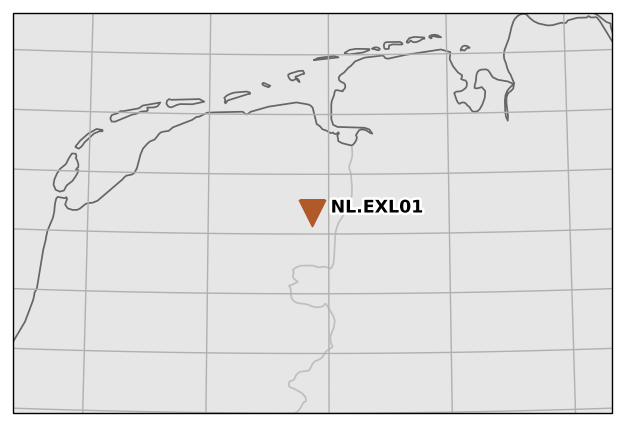

In [21]:
fig=NL_EXL.inventory.plot(projection='local',resolution='f')

In [22]:
print(NL_EXL.inventory)

Inventory created at 2020-09-17T10:51:30.683568Z
	Created by: ObsPy 1.2.1
		    https://www.obspy.org
	Sending institution: Royal Netherlands Meteorological Institute (KNMI)
	Contains:
		Networks (1):
			NL
		Stations (1):
			NL.EXL01 (Exloo Infrasound Array)
		Channels (2):
			NL.EXL01.00.HDF, NL.EXL01.01.HDF


Of course the inventory can be written to disk:


Station EXL01 (Exloo Infrasound Array)
	Station Code: EXL01
	Channel Count: None/None (Selected/Total)
	2017-07-20T18:00:00.000000Z - 
	Access: open Alternate Code: EXL 
	Latitude: 52.91, Longitude: 6.87, Elevation: 6.0 m
	Available Channels:
		EXL01.00.HDF, EXL01.01.HDF
Inventory created at 2020-09-17T10:51:30.683568Z
	Created by: ObsPy 1.2.1
		    https://www.obspy.org
	Sending institution: Royal Netherlands Meteorological Institute (KNMI)
	Contains:
		Networks (1):
			NL
		Stations (1):
			NL.EXL01 (Exloo Infrasound Array)
		Channels (2):
			NL.EXL01.00.HDF, NL.EXL01.01.HDF
--------------------------------------------------------------------------------
Channel 'HDF', Location '00' (Microbarometric pressure)
	Time range: 2017-07-20T18:00:00.000000Z - --
	Latitude: 52.91, Longitude: 6.87, Elevation: 6.0 m, Local Depth: 1.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): KNMI-mb 500s (KNMI 500s di

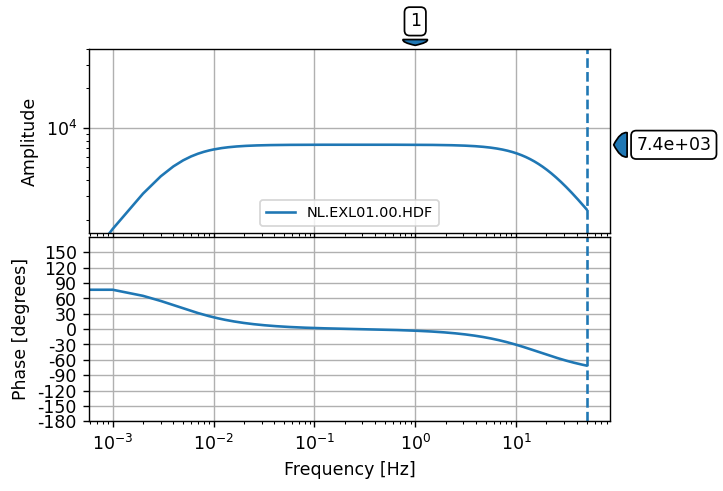

--------------------------------------------------------------------------------
Channel 'HDF', Location '01' (Microbarometric pressure)
	Time range: 2017-07-20T18:00:00.000000Z - --
	Latitude: 52.91, Longitude: 6.87, Elevation: 6.0 m, Local Depth: 1.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): KNMI-mb 500s (KNMI 500s differential microbarometer)
	Response information available
Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 7438.11 defined at 1.000 Hz
	8 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: 

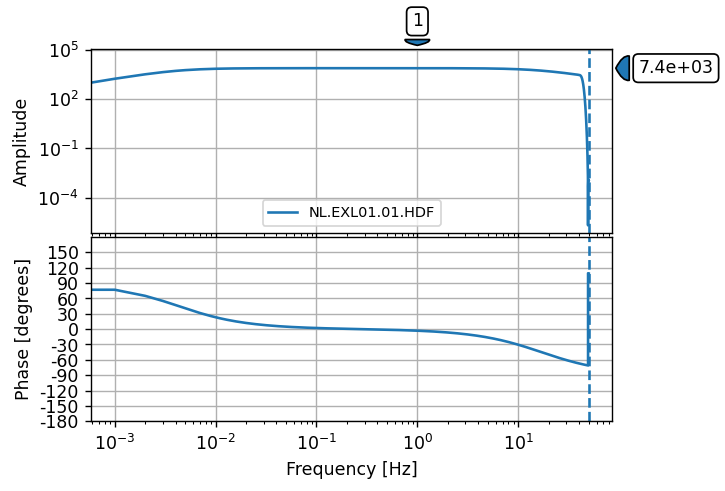

Writing out [ NL.EXL/NL.EXL01.xml ] ...



In [23]:
NL_EXL.write(plot_response=True, write_group=False)